In [31]:
%load_ext autoreload
%autoreload 2

import os,sys
import datetime as dt
import pandas as pd

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.insert(0, '/scratch/users/udemir15/ELEC491/bassline_transcription')

from utilities import *
import bassline_transcriber.transcription as transcription
from dataset import df_from_codes, load_data, count_same_phrases

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialization

In [32]:
directories = get_directories('../data/directories.json')

In [40]:
M = 8

data_params = {'dataset_path': '/scratch/users/udemir15/ELEC491/bassline_transcription/data/datasets/[28, 51]/sus',
               'dataset_name': 'TechHouse_bassline_representations_4020',
               'scale_type': 'min',
               'M': M}

X, titles = load_data(data_params)
#X = append_SOS(X)

frequencies = np.unique(X, return_counts=True)

K = X.max()+1 # Number of classes, assumes consecutive
sequence_length = X.shape[1]

print('Number of classes: {}\nSequence Length: {}'.format(K, sequence_length))
print('Number of data points: {}'.format(X.shape[0]))

Number of classes: 26
Sequence Length: 64
Number of data points: 4020


In [41]:
print_beat_matrix(X[0], M, SIL=0, SUS=26)

SIL: 0, SUS: 26

        Bar 0            Bar 1        
Beat 0: [ 0  9 25 25]   [ 0 10 25  9]
Beat 1: [25  4 25  7]   [25  4 25  7]
Beat 2: [ 0  9 25 25]   [ 0  9 25 25]
Beat 3: [25  0  4  7]   [25  4 25  7]

        Bar 2            Bar 3        
Beat 0: [ 0  9 25 25]   [ 0  9 25 25]
Beat 1: [25  0  4  7]   [25  4 25  7]
Beat 2: [ 0  9 25 25]   [ 0  9 25 25]
Beat 3: [25  4 25  7]   [25  4 25  7]


In [ ]:
df = df_from_codes(X, titles)

## Distribution Inspection

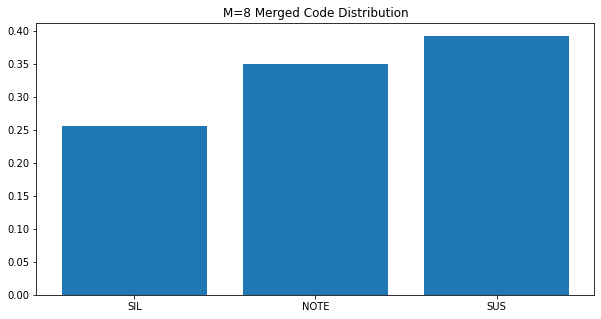

In [7]:
silence_count = frequencies[1][0]
note_count = frequencies[1][1:-1].sum()
sustain_count = frequencies[1][-1]

merged_frequencies = np.array([silence_count, note_count, sustain_count])

fig ,ax = plt.subplots(figsize=(10,5))
plot_title = 'M={} Merged Code Distribution'.format(M)
ax.set_title(plot_title, fontsize=12)
ax.bar(['SIL', 'NOTE', 'SUS'], merged_frequencies/merged_frequencies.sum())

#plt.savefig(os.path.join(directories['plot']['figures']+'/dataset', 'Merged_Code_Distribution_M{}.jpg'.format(M)))
plt.show()

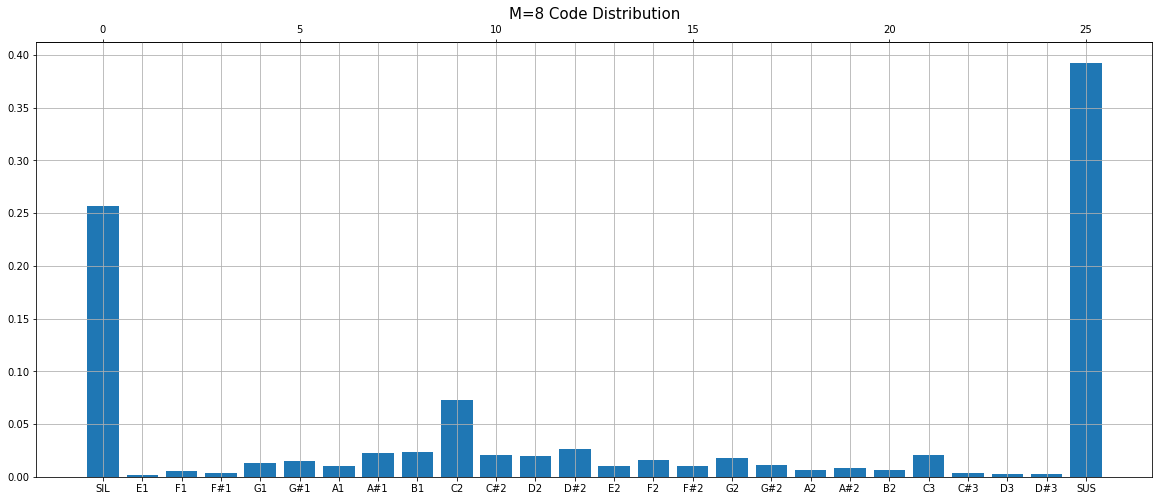

In [14]:
keys = ['SIL'] + ['E1', 'F1', 'F#1', 'G1', 'G#1', 'A1', 'A#1', 'B1']+ \
        ['C2', 'C#2', 'D2', 'D#2', 'E2', 'F2', 'F#2', 'G2', 'G#2', 'A2', 'A#2', 'B2']+ \
        ['C3', 'C#3', 'D3','D#3']+ ['SUS']

fig ,ax = plt.subplots(figsize=(20,8))
plot_title = 'M={} Code Distribution'.format(M)
ax.set_title(plot_title, fontsize=15)
ax.bar(keys, frequencies[1]/frequencies[1].sum())
ax.grid()
secax = ax.secondary_xaxis('top')

#plt.savefig(os.path.join(directories['plot']['figures']+'/dataset', 'Code_Distribution_M{}.jpg'.format(M)))
plt.show()

weights = frequencies[1].max() / frequencies[1]
weights /= weights.sum()

## Similarity Measure

In [15]:
counter = {b: {'01': 0, '02': 0, '03': 0, '12': 0, '13': 0, '23': 0} for b in range(4)}
for vector in X: #[:, 1:]:
    count_same_phrases(vector, M, counter)
for vals in counter.values():
    print(vals)

{'01': 528, '02': 560, '03': 412, '12': 1210, '13': 1388, '23': 1234}
{'01': 1137, '02': 1105, '03': 848, '12': 1263, '13': 1320, '23': 1273}
{'01': 1245, '02': 1281, '03': 910, '12': 1303, '13': 1328, '23': 1265}
{'01': 1114, '02': 1252, '03': 738, '12': 1120, '13': 1110, '23': 993}


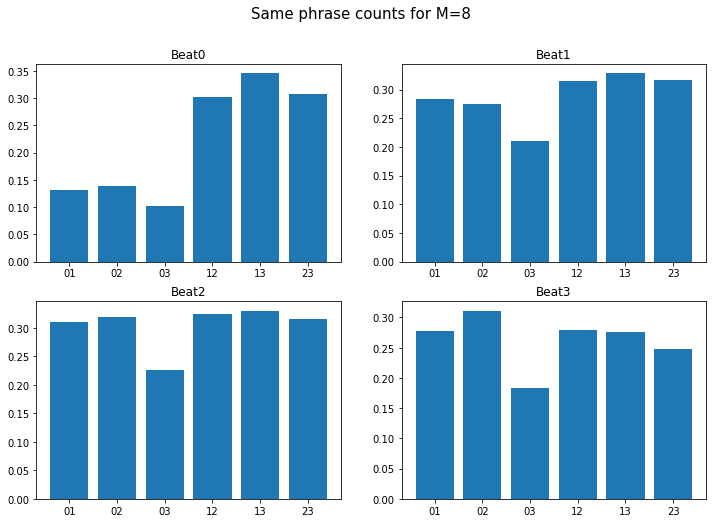

In [16]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
fig.suptitle('Same phrase counts for M={}'.format(M), fontsize=15)

ax[0][0].bar(counter[0].keys(), np.array(list(counter[0].values()))/len(X))
ax[0][0].set_title('Beat0')
ax[0][1].bar(counter[1].keys(), np.array(list(counter[1].values()))/len(X))
ax[0][1].set_title('Beat1')
ax[1][0].bar(counter[2].keys(), np.array(list(counter[2].values()))/len(X))
ax[1][0].set_title('Beat2')
ax[1][1].bar(counter[3].keys(), np.array(list(counter[3].values()))/len(X))
ax[1][1].set_title('Beat3')

#plt.savefig(os.path.join(directories['plot']['figures']+'/dataset', 'Same_Phrase_Counts_M{}.jpg'.format(M)))
plt.show()

## Without Sustain

In [25]:
X_no_sus = transcription.replace_sustain(X, sustain_code=25)
no_sus_frequencies = np.unique(X_no_sus, return_counts=True)

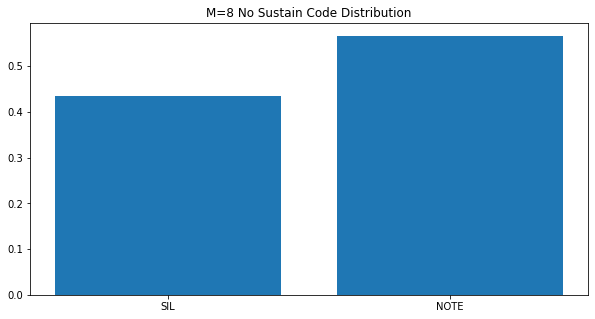

In [30]:
silence_count = no_sus_frequencies[1][0]
note_count = no_sus_frequencies[1][1:].sum()

merged_frequencies = np.array([silence_count, note_count])

fig ,ax = plt.subplots(figsize=(10,5))
plot_title = 'M={} No Sustain Code Distribution'.format(M)
ax.set_title(plot_title, fontsize=12)
ax.bar(['SIL', 'NOTE'], merged_frequencies/merged_frequencies.sum())

#plt.savefig(os.path.join(directories['plot']['figures']+'/dataset', 'Merged_Code_Distribution_M{}.jpg'.format(M)))
plt.show()

## Representation Printing

In [18]:
idx = 56
title = titles[idx]
print(title)
vector = X[idx]
print_beat_matrix(vector, M)
print('\n')
print_transposed_beat_matrix(vector, M)

Spacefunk Dub - Bayioo (Original Mix)
SIL: 1, SUS: 26

        Bar 0            Bar 1        
Beat 0: [ 0 25 25 25]   [ 0 25 25 25]
Beat 1: [25 25 25 25]   [ 9  0 25  5]
Beat 2: [25  9  0  9]   [0 9 0 9]
Beat 3: [ 0 25  9  1]   [25  0  9  0]

        Bar 2            Bar 3        
Beat 0: [ 1  0 25 25]   [ 1  0 25 25]
Beat 1: [ 9  0 25 25]   [ 9  0 25 25]
Beat 2: [25  9 25 25]   [ 5  9 25 25]
Beat 3: [25 25 25  0]   [25 25 25  0]


SIL: 1, SUS: 26

       Beat 0           Beat 1       
Bar 0: [ 0 25 25 25]   [25 25 25 25]
Bar 1: [ 0 25 25 25]   [ 9  0 25  5]
Bar 2: [ 1  0 25 25]   [ 9  0 25 25]
Bar 3: [ 1  0 25 25]   [ 9  0 25 25]

       Beat 2           Beat 3       
Bar 0: [25  9  0  9]   [ 0 25  9  1]
Bar 1: [0 9 0 9]   [25  0  9  0]
Bar 2: [25  9 25 25]   [25 25 25  0]
Bar 3: [ 5  9 25 25]   [25 25 25  0]


		Spacefunk Dub - Bayioo (Original Mix)

Chorus

Fs = 44100, x.shape = (84010,), x.dtype = float32


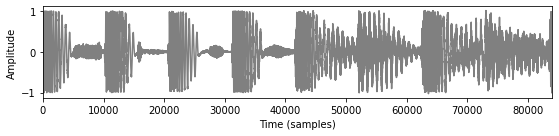

Bassline

Fs = 44100, x.shape = (84010,), x.dtype = float64


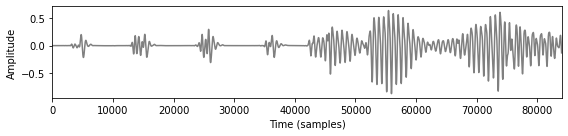

In [19]:
inspect_audio_outputs(title, directories, start=0, end=1)

In [ ]:
# Dreams of Morjim      | drop mistake
# Camilo Do Santos - Bubba Mint (Original Mix)   | note melodic

## MISTAKES

quantization before coding. (COMPLETED)

In [6]:
track_dicts, track_titles = get_track_dicts(directories, 'TechHouse_total_track_dicts.json')

In [11]:
M=1

repres = []
for title in track_titles:
    
    try:
    
        key = track_dicts[title]['Key'].split(' ')[0]

        quantized_pitch_track = load_quantized_pitch_track(title, directories)[1]
        midi_sequence = transcription.frequency_to_midi_sequence(quantized_pitch_track)
        midi_sequence = transcription.downsample_midi_number_sequence(midi_sequence, M=M)
        representation = transcription.encode_midi_sequence(midi_sequence, key=key)
        repres.append(representation)
        
        export_function(representation, directories['symbolic_representation'][str(M)], title) 
        
    except KeyboardInterrupt:
        sys.exit()
        pass        
    except:
        pass
        
X = np.stack(repres, axis=0)
print(X.shape)

(9851, 512)


# Control

In [10]:
counter = 0

rep = []
for row in X:
    for idx, val in enumerate(row[:-1]):
        
        if val == row[idx+1]:
            
            if val != 100:
                counter += 1
                #print(row)
                #print(idx)
                #print(val)
                #break
                rep.append(val)
                print(row[idx-1],val,row[idx+1], row[idx+2],row[idx+3])
print(counter)

0


## New Representation

In [ ]:
from bassline_transcriber.transcription.representation import encode_midi_array_new

In [ ]:
#M = 1
sustain_silence=-1
sustain_note=-2

Y = np.zeros((len(titles), 4*4*(32//M)), dtype=np.int64)
for i, title in enumerate(titles):
    
    midi_array = load_bassline_midi_array(title, directories, M)
    new_representation = encode_midi_array_new(midi_array, 8, M, 4, sustain_silence=sustain_silence, sustain_note=sustain_note)
    Y[i] = new_representation
    
    
new_frequencies = np.unique(Y, return_counts=True)

new_frequencies_merged = (['SUS_NOTE', 'SUS_SIL', 'SIL', 'NOTE'], np.array([new_frequencies[1][0], new_frequencies[1][1],
                                                                   new_frequencies[1][2], new_frequencies[1][3:].sum()]))

new_frequencies_hard_merged = (['SIL', 'NOTE'], np.array([new_frequencies[1][1:3].sum(),
                                                          new_frequencies[1][0]+new_frequencies[1][3:].sum()]))

In [ ]:
fig ,ax = plt.subplots(figsize=(10,5))
plot_title = 'M={} Code Distribution with Separate Sustains'.format(M)
ax.set_title(plot_title, fontsize=12)
ax.bar(new_frequencies_merged[0], new_frequencies_merged[1]/new_frequencies_merged[1].sum())

#plt.savefig(os.path.join(directories['plot']['figures']+'/dataset', 'Code_Distribution_Separate_Sustains_M{}.jpg'.format(M)))
plt.show()

In [ ]:
fig ,ax = plt.subplots(figsize=(10,5))
plot_title = 'M={} Code Distribution without sustain'.format(M)
ax.set_title(plot_title, fontsize=12)
ax.bar(new_frequencies_hard_merged[0], new_frequencies_hard_merged[1]/new_frequencies_hard_merged[1].sum())

#plt.savefig(os.path.join(directories['plot']['figures']+'/dataset', 'Code_Distribution_Without_Sustains_M{}.jpg'.format(M)))
plt.show()